In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from lmfit.models import ExpressionModel
import numpy as np
%matplotlib widget

In [2]:
data = pd.read_excel("../data/raw/lattice_parameters.xlsx")

In [3]:
data.head()

,pressure(GPa),a(A),esd_a,c(A),esd_c,vol(A^3),esd_vol,phase,file_no
0,0.0,3.009682,0.000334,20.889203,0.003259,163.868,0.024,166,1
1,3.6,2.998665,0.000639,20.768160,0.008181,161.728,0.063,166,2
2,12.0,2.979991,0.000487,20.624416,0.007187,158.614,0.057,166,3
3,24.0,2.951677,0.000639,20.403757,0.006564,153.950,0.058,166,4
4,31.0,2.930334,0.000486,20.306385,0.006775,151.007,0.054,166,5


In [4]:
df166 = data[(data["phase"] == 166)]
df191 = data[(data["phase"] == 191)]

Text(0.02, 0.5, 'Lattice parameters ($\\AA$)')

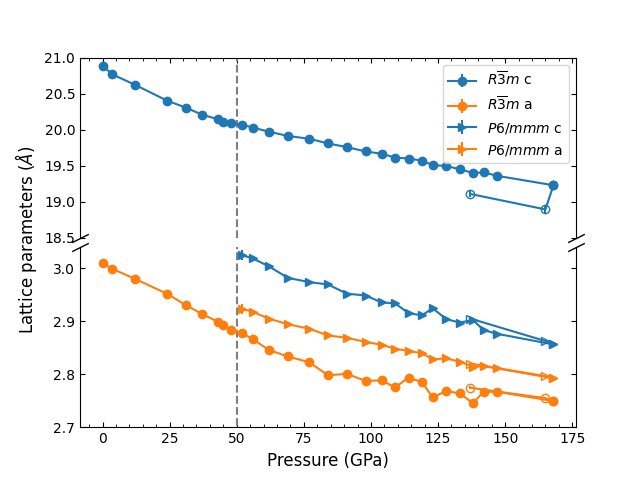

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05)
ax1.errorbar(df166['pressure(GPa)'][:-2], df166['c(A)'][:-2],
             yerr=df166['esd_c'][:-2], label="$R\overline{3}m$ c", c="C0",
             marker="o")
#for legend
ax1.errorbar(df166['pressure(GPa)'], df166['a(A)'], yerr=df166['esd_a'],
             label="$R\overline{3}m$ a", c="C1", marker="o")
ax1.errorbar(df191['pressure(GPa)'][:-2], df191['c(A)'][:-2],
             label="$P6/mmm$ c", yerr=df191['esd_c'][:-2], c="C0", marker=">")
ax1.errorbar(df191['pressure(GPa)'][:-2], df191['a(A)'][:-2],
             label="$P6/mmm$ a", yerr=df191['esd_a'][:-2], c="C1", marker=">")

ax2.errorbar(df166['pressure(GPa)'][:-2], df166['a(A)'][:-2],
             yerr=df166['esd_a'][:-2], c="C1", marker="o")
ax2.errorbar(df191['pressure(GPa)'][:-2], df191['c(A)'][:-2],
             yerr=df191['esd_c'][:-2], c="C0", marker=">")
ax2.errorbar(df191['pressure(GPa)'][:-2], df191['a(A)'][:-2],
             yerr=df191['esd_a'][:-2], c="C1", marker=">")
#unloading
ax1.errorbar(df166['pressure(GPa)'][-3:], df166['c(A)'][-3:],
             yerr=df166['esd_c'][-3:], c="C0", marker="o",
             markerfacecolor="None")
ax2.errorbar(df166['pressure(GPa)'][-3:], df166['a(A)'][-3:],
             yerr=df166['esd_a'][-3:], c="C1", marker="o",
             markerfacecolor="None")
ax2.errorbar(df191['pressure(GPa)'][-3:], df191['c(A)'][-3:],
             yerr=df191['esd_c'][-3:], c="C0", marker=">",
             markerfacecolor="None")
ax2.errorbar(df191['pressure(GPa)'][-3:], df191['a(A)'][-3:],
             yerr=df191['esd_a'][-3:], c="C1", marker=">",
             markerfacecolor="None")
ax1.set_xlabel("")
ax2.set_xlabel("Pressure (GPa)", fontsize=12)
ax1.plot([50, 50], [15, 21], c="tab:gray", linestyle="--")
ax2.plot([50, 50], [2.5, 3.2], c="tab:gray", linestyle="--")
ax1.set_ylim(18.5, 21)
ax2.set_ylim(2.7, 3.04)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(top=True, right=True, bottom=False, which="both",
                direction="in")
ax2.tick_params(top=False, right=True, bottom=True, which="both",
                direction="in")
ax2.xaxis.set_minor_locator(AutoMinorLocator())
kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.legend()
# fig.add_subplot(111, frameon=False)
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False,
#                 left=False, right=False)
fig.supylabel("Lattice parameters ($\AA$)", fontsize=12)
# plt.tight_layout()
# from google.colab import files
# plt.savefig("fig1.pdf")
# files.download("fig1.pdf")

In [6]:
refdata = pd.read_csv("../data/external/ref_data.csv", names=["pressure(GPa)", "volume(A^3)"],
                      skiprows=1)

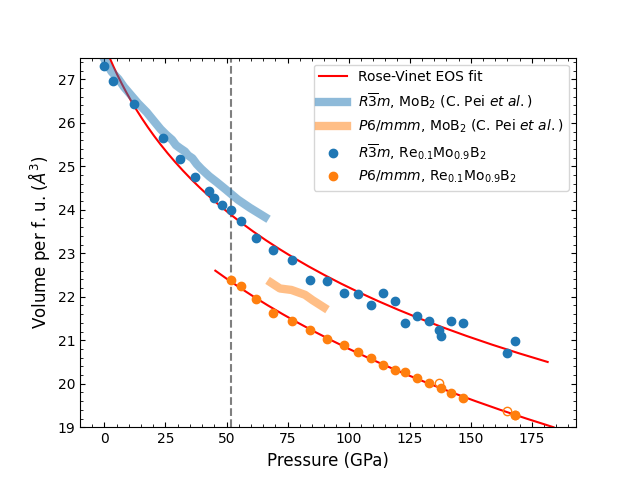

In [7]:
fig, ax = plt.subplots()
ax.errorbar(df166["pressure(GPa)"], df166["vol(A^3)"]/6, yerr=df166['esd_vol'],
            label="$R\overline{3}m$, Re$_{0.1}$Mo$_{0.9}$B$_2$", c="C0", marker="o", linewidth=0)
ax.errorbar(df191["pressure(GPa)"][:-2], df191["vol(A^3)"][:-2],
            yerr=df191['esd_vol'][:-2], label="$P6/mmm$, Re$_{0.1}$Mo$_{0.9}$B$_2$", c="C1", marker="o",
            linewidth=0)
ax.errorbar(df191["pressure(GPa)"][-3:], df191["vol(A^3)"][-3:],
            yerr=df191['esd_vol'][-3:], c="C1", marker="o",
            linewidth=0, markerfacecolor="None")
ax.plot([52, 52], [19, 27.5], c="tab:gray", linestyle="--")
# B_0 = 365.681217
# V_0 = 163.698712/6
# B_0d = 1.15530354
# V = np.arange(24, 28, 0.5)
B_0 = 192.903887
V_0 = 166.718067/6
B_0d = 7.75511901
V = np.arange(20.5, 28, 0.2)
predicted_pressure = 3 * B_0 * (1 - (V / V_0) ** (1 / 3)) / (V / V_0) ** (2 / 3) \
                     * np.exp(3 * (1 - (V / V_0) ** (1 / 3)) * (B_0d - 1) / 2)
ax.plot(predicted_pressure, V, c="r", label="Rose-Vinet EOS fit")
B_0 = 347.742249
V_0 = 25.0273216
B_0d = 4.90257289
V = np.arange(19, 22.6, 0.2)
predicted_pressure = 3 * B_0 * (1 - (V / V_0) ** (1 / 3)) / (V / V_0) ** (2 / 3) \
                     * np.exp(3 * (1 - (V / V_0) ** (1 / 3)) * (B_0d - 1) / 2)
ax.plot(predicted_pressure, V, c="r")
ax.plot(refdata["pressure(GPa)"][:24], refdata["volume(A^3)"][:24],
        linewidth=6, alpha=0.5, label="$R\overline{3}m$, MoB$_2$ (C. Pei $et$ $al.$)")
ax.plot(refdata["pressure(GPa)"][24:], refdata["volume(A^3)"][24:],
        linewidth=6, alpha=0.5, label="$P6/mmm$, MoB$_2$ (C. Pei $et$ $al.$)")
ax.set_ylim([19, 27.5])
ax.tick_params(top=True, right=True, which="both", direction="in")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Volume per f. u. ($\AA^3$)", fontsize=12)
ax.set_xlabel("Pressure (GPa)", fontsize=12)
plt.legend()
# plt.tight_layout()
# from google.colab import files
# plt.savefig("fig2.pdf")
# files.download("fig2.pdf")

In [8]:
mask = (df166["a(A)"].diff()>0) == False

model = ExpressionModel("3 * B_0 * (1 - (x / V_0)**(1/3)) / (x / V_0)**(2/3)"
                        " * exp(3 * (1 - (x / V_0)**(1/3)) * (B_0d - 1) / 2)")
params = model.make_params(B_0=400, B_0d=2.1, V_0=170)
# output = model.fit(df166["pressure(GPa)"][mask], params, x=df166["vol(A^3)"][mask])
output = model.fit(df166["pressure(GPa)"], params, x=df166["vol(A^3)"])
print(output.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 30
    # variables        = 3
    chi-square         = 1161.23020
    reduced chi-square = 43.0085261
    Akaike info crit   = 115.681136
    Bayesian info crit = 119.884728
    R-squared          = 0.98347283
[[Variables]]
    B_0:   192.903980 +/- 62.3659601 (32.33%) (init = 400)
    V_0:   166.718062 +/- 3.56111646 (2.14%) (init = 170)
    B_0d:  7.75511688 +/- 1.41317438 (18.22%) (init = 2.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(B_0, B_0d) = -0.966
    C(B_0, V_0)  = -0.964
    C(V_0, B_0d) = 0.865


In [9]:
model = ExpressionModel("3 * B_0 * (1 - (x / V_0)**(1/3)) / (x / V_0)**(2/3)"
                        " * exp(3 * (1 - (x / V_0)**(1/3)) * (B_0d - 1) / 2)")
params = model.make_params(B_0=400, B_0d=4.5, V_0=25)
output = model.fit(df191["pressure(GPa)"][:-2], params, x=df191["vol(A^3)"][:-2])
print(output.fit_report())

[[Model]]
    Model(_eval)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 19
    # variables        = 3
    chi-square         = 27.0688564
    reduced chi-square = 1.69180353
    Akaike info crit   = 12.7249527
    Bayesian info crit = 15.5582696
    R-squared          = 0.99864167
[[Variables]]
    B_0:   347.742205 +/- 51.7694680 (14.89%) (init = 400)
    V_0:   25.0273218 +/- 0.27481857 (1.10%) (init = 25)
    B_0d:  4.90257348 +/- 0.69437693 (14.16%) (init = 4.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(B_0, V_0)  = -0.993
    C(B_0, B_0d) = -0.992
    C(V_0, B_0d) = 0.970


TiB2: BT0 = 256.7 GPa,  B’T0 = 3.83. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5198855/

In [10]:
# data = pd.read_excel("lattice_parameters2.xlsx")
# df166 = data[(data["phase"] == 166)]
# df191 = data[(data["phase"] == 191)]

In [ ]:
fig0, (ax1, ax2, ax) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 1.2]},
                                    sharex=True, figsize=(7.5, 7.5))
fig0.subplots_adjust(hspace=0.01)
ax1.errorbar(df166['pressure(GPa)'][:-2], df166['c(A)'][:-2],
             yerr=df166['esd_c'][:-2], label="$R\overline{3}m$ c", c="C0",
             marker="o")
#for legend
ax1.errorbar(df166['pressure(GPa)'], df166['a(A)'], yerr=df166['esd_a'],
             label="$R\overline{3}m$ a", c="C1", marker="o")
ax1.errorbar(df191['pressure(GPa)'][:-2], df191['c(A)'][:-2],
             label="$P6/mmm$ c", yerr=df191['esd_c'][:-2], c="C0", marker=">")
ax1.errorbar(df191['pressure(GPa)'][:-2], df191['a(A)'][:-2],
             label="$P6/mmm$ a", yerr=df191['esd_a'][:-2], c="C1", marker=">")

ax2.errorbar(df166['pressure(GPa)'][:-2], df166['a(A)'][:-2],
             yerr=df166['esd_a'][:-2], c="C1", marker="o")
ax2.errorbar(df191['pressure(GPa)'][:-2], df191['c(A)'][:-2],
             yerr=df191['esd_c'][:-2], c="C0", marker=">")
ax2.errorbar(df191['pressure(GPa)'][:-2], df191['a(A)'][:-2],
             yerr=df191['esd_a'][:-2], c="C1", marker=">")
#unloading
ax1.errorbar(df166['pressure(GPa)'][-3:], df166['c(A)'][-3:],
             yerr=df166['esd_c'][-3:], c="C0", marker="o",
             markerfacecolor="None")
ax2.errorbar(df166['pressure(GPa)'][-3:], df166['a(A)'][-3:],
             yerr=df166['esd_a'][-3:], c="C1", marker="o",
             markerfacecolor="None")
ax2.errorbar(df191['pressure(GPa)'][-3:], df191['c(A)'][-3:],
             yerr=df191['esd_c'][-3:], c="C0", marker=">",
             markerfacecolor="None")
ax2.errorbar(df191['pressure(GPa)'][-3:], df191['a(A)'][-3:],
             yerr=df191['esd_a'][-3:], c="C1", marker=">",
             markerfacecolor="None")
ax2.set_xlabel("Pressure (GPa)")
ax1.plot([50, 50], [15, 21], c="tab:gray", linestyle="--")
ax2.plot([50, 50], [2.5, 3.2], c="tab:gray", linestyle="--")
ax1.text(-18.5, 18.2, 'Lattice parameters($\AA$)', va='center', rotation='vertical',
         fontsize=12)
ax1.set_ylim(18.5, 21)
ax2.set_ylim(2.7, 3.04)
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(top=True, right=True, bottom=False, which="both",
                direction="in")
ax2.tick_params(top=False, right=True, bottom=True, which="both",
                direction="in")
ax2.xaxis.set_minor_locator(AutoMinorLocator())
kwargs = dict(marker=[(-1, -0.5), (1, 0.5)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
ax1.legend()
# volumn
ax.errorbar(df166["pressure(GPa)"], df166["vol(A^3)"]/6, yerr=df166['esd_vol'],
            label="$R\overline{3}m$, Re$_{0.1}$Mo$_{0.9}$B$_2$", c="C0", marker="o", linewidth=0)
ax.errorbar(df191["pressure(GPa)"][:-2], df191["vol(A^3)"][:-2],
            yerr=df191['esd_vol'][:-2], label="$P6/mmm$, Re$_{0.1}$Mo$_{0.9}$B$_2$", c="C1", marker="o",
            linewidth=0)
ax.errorbar(df191["pressure(GPa)"][-3:], df191["vol(A^3)"][-3:],
            yerr=df191['esd_vol'][-3:], c="C1", marker="o",
            linewidth=0, markerfacecolor="None")
ax.plot([50, 50], [19, 27.5], c="tab:gray", linestyle="--")
B_0 = 192.903887
V_0 = 166.718067/6
B_0d = 7.75511901
V = np.arange(20.5, 28, 0.2)
predicted_pressure = 3 * B_0 * (1 - (V / V_0) ** (1 / 3)) / (V / V_0) ** (2 / 3) \
                     * np.exp(3 * (1 - (V / V_0) ** (1 / 3)) * (B_0d - 1) / 2)
ax.plot(predicted_pressure, V, c="r", label="Rose-Vinet EOS fit")
B_0 = 347.742249
V_0 = 25.0273216
B_0d = 4.90257289
V = np.arange(19, 22.6, 0.2)
predicted_pressure = 3 * B_0 * (1 - (V / V_0) ** (1 / 3)) / (V / V_0) ** (2 / 3) \
                     * np.exp(3 * (1 - (V / V_0) ** (1 / 3)) * (B_0d - 1) / 2)
ax.plot(predicted_pressure, V, c="r")
ax.plot(refdata["pressure(GPa)"][:24], refdata["volume(A^3)"][:24],
        linewidth=6, alpha=0.5, label="$R\overline{3}m$, MoB$_2$ (C. Pei $et$ $al.$)")
ax.plot(refdata["pressure(GPa)"][24:], refdata["volume(A^3)"][24:],
        linewidth=6, alpha=0.5, label="$P6/mmm$, MoB$_2$ (C. Pei $et$ $al.$)")
ax.set_ylim([19, 27.5])
ax.tick_params(top=True, right=True, which="both", direction="in")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel("Volume per f. u. ($\AA^3$)", fontsize=12)
ax.set_xlabel("Pressure (GPa)", fontsize=12)
plt.legend()
plt.xlim(-2, 175)
# plt.tight_layout()
# from google.colab import files
# plt.savefig("figintegrated.pdf")
# files.download("figintegrated.pdf")

Plots for refinement

In [3]:
from pathlib import Path

In [1]:
data_dict = {}